In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../') # path to bemcs

import bemcs
import bemcs.kernels_stress_displacement as kernels

In [2]:
# create a uniform mesh of the free surface
n_elements = 20
L_fault = 10 # fault length in x
xmesh = np.linspace(-L_fault/2,L_fault/2,n_elements+1)
x1 = xmesh[0:-1]
x2 = xmesh[1:]
y1 = 0*x1
y2 = 0*x2

elements = []
element = {}
for i in range(n_elements):
    element["x1"] = x1[i]
    element["y1"] = y1[i]
    element["x2"] = x2[i]
    element["y2"] = y2[i]
    elements.append(element.copy())
elements = bemcs.standardize_elements(elements)


IN BEMCS - physical_displacements=array([1., 1., 1.])
IN BEMCS - quadratic_coefficients=array([1., 1., 1.])


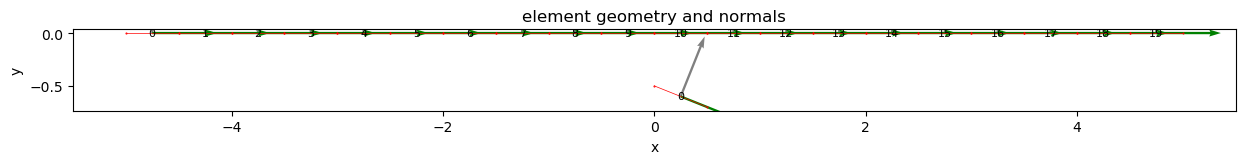

In [6]:
# create a source (use constant slip)
element = {}
source = []
element["x1"] = 0
element["x2"] = 0.5
element["y1"] = -0.5
element["y2"] = -0.7
source.append(element.copy())
source = bemcs.standardize_elements(source)

quadratic_source = bemcs.get_quadratic_coefficients_for_linear_slip(source[0]["half_length"], 
    np.array((-source[0]["half_length"],0,source[0]["half_length"])), 1., 1.)

plt.figure(figsize=(15,10))
bemcs.plot_element_geometry(elements)
bemcs.plot_element_geometry(source)
plt.show()

In [35]:
def compute_tractionkernels(elements,kernels):    
    Kxx = kernels[0]
    Kyy = kernels[1]
    Kxy = kernels[2]
    nrows = np.shape(Kxx)[0]
    ncols = np.shape(Kxx)[1]

    tx = np.zeros_like(Kxx)
    ty = np.zeros_like(Kxx)
    # unit vector in normal direction
    nvec = np.zeros((nrows,2))

    for i in range(nrows):
        nvec[i,:] = np.array((elements[i]["x_normal"],elements[i]["y_normal"]))
    nx_matrix = np.zeros_like(Kxx)
    ny_matrix = np.zeros_like(Kxx)

    nx_matrix[:,0::3] = nvec[:,0]
    nx_matrix[:,1::3] = nvec[:,0]
    nx_matrix[:,2::3] = nvec[:,0]
    ny_matrix[:,0::3] = nvec[:,1]
    ny_matrix[:,1::3] = nvec[:,1]
    ny_matrix[:,2::3] = nvec[:,1]

    # traction vector t = n.σ
    tx = Kxx*nx_matrix + Kxy*ny_matrix
    ty = Kxy*nx_matrix + Kyy*ny_matrix

    return tx,ty

# compute displacement and stress kernels
# Elastic parameters
mu = 1
nu = 0.25
# unit vector in normal direction
nvec = np.zeros((n_elements,2))
for i in range(n_elements):
    nvec[i,:] = np.array((elements[i]["x_normal"],elements[i]["y_normal"]))
x_obs = np.zeros((n_elements,1)) 
y_obs = np.zeros((n_elements,1)) 
for i in range(n_elements):
    x_obs[i,0] = 0.5*(elements[i]["x1"]+elements[i]["x2"]) - nvec[i,0]*1e-16
    y_obs[i,0] = 0.5*(elements[i]["y1"]+elements[i]["y2"]) - nvec[i,1]*1e-16

# compute shear and tensile stress kernels
# kernels are [Kxx,Kyy,Kxy,Gx,Gy] x [Nobs x Ncoefficients]
# the last argument passed is a flag for shear/tensile source (1 - shear, 0 - tensile)
kernels_s = kernels.get_quadratic_displacement_stress_kernel(x_obs,y_obs,elements,mu,nu,1)
kernels_n = kernels.get_quadratic_displacement_stress_kernel(x_obs,y_obs,elements,mu,nu,0)

# convert to traction kernels (tx = Kxx*nx + Kxy*ny,ty = Kxy*nx + Kyy*ny)
tractionkernels_s = compute_tractionkernels(elements,kernels_s)
tractionkernels_n = compute_tractionkernels(elements,kernels_n)
